# Problem Sheet 7 - Subset selection

In this and the following exercises, we want to explore different methods of linear model selection.

In the lecture you've learned about problems that might occur in datasets with many predictors (high $p$)and a low number of samples (low $n$).
Ways out could be:
* Subset selection - try to find a suitable subset of predictors
* Skrinkage/Regularization - increase weights of *important* predictors, decrease weights of *unimportant* ones
* Dimension reduction - Build linear combinations $v_i, i=1,\ldots,M$ of predictors and fit a model using these vectors instead of predictors with $M < p$

We always have to keep in mind that it's in general not wise to select the model with the minimal training error, due to the danger of overfitting.
Our goal is to find a model that performs well on a test set.
This refers to a subset of samples that are completely held out from training (and also cross-validation).

## Problem 1 - Best subset selection

We want to implement the **best subset selection** algorithm from the lecture:
1. Let $\mathcal{M}_0$ denote the *null model*, which contains no predictors.
2. For $k = 1, 2, \ldots, p$:
  1. Fit all $p \choose k$ models that contain exactly $k$ predictors.
  2. Pick the best among these and call it $\mathcal{M}_k$, while the best is the one with highest $R^2$ score.
3. Select a single best model from among $\mathcal{M}_0, \ldots \mathcal{M}_p$ using one of the following methods:
    * cross-validated prediction error
    * $C_p$ (or equivalently AIC - Akaike information criterion)
    * BIC - Bayesian information criterion
    * adjusted $R^2$


### Problem 1.1 - Understanding steps 1 and 2
    
The algorithm `bestSubsetComputation` belows contains the implementation of step 1 and step 2.

**Task**: Understand the following code and add comments as you wish.

In [1]:
import numpy as np

from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def bestSubsetComputation(X, y, scoring_func = r2_score):
    """ Input: X - predictor array of size (n,p)
               y - array of size (n,)
               scoring_func - function that takes two arguments y_true
                  and y_pred, and returns a score
               
    """
    
    # Get the number of samples and the number of predictors 
    n, p = X.shape
    
    # Prepare lists that keep the best scores and models:
    #     best_score[i] keeps the best score in a model i predictors
    #     best_model[i] keeps the best model using i predictors
    
    best_score = []
    best_model = []

    ### First step in best subset selection algorithm
    
    # The model containing no predictors simply predicts the sample mean
    ybar = y.mean()
    yhat = ybar * np.ones_like(y)

    best_score.append(scoring_func(y, yhat))
    best_model.append( () )
    
    ### Second step in best subset selection algorithm

    # Loop over k - number of predictors in our model
    for k in range(1,p+1):

        best_model.append( () )
        best_score.append(0.)

        for l in combinations(range(p),k):

            lr = LinearRegression()
            lrfit = lr.fit(X[:,l],y)
            yhat = lrfit.predict(X[:,l])

            this_score = scoring_func(y,yhat)
            
            if this_score > best_score[k]:
                best_score[k] = this_score
                best_model[k] = l
                
    return (best_model, best_score)

**Task**: Load the diabetes data set form sklearn. If you forgot how to do this have a look at problem sheet 6.
Store the predictors in an array `X`, and the targets in an array `y`.

**Solution**:

In [2]:
from sklearn.datasets import load_diabetes
data = load_diabetes()

#print(data.DESCR)
X = data.data
y = data.target


**Task**: Use the function `train_test_split` from `sklearn.model_selection` to split the data into a training and test set. Use as `test_size=0.2` and `random_state=1`.

**Solution**:

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

**Task**:
Apply the `bestSubsetComputation` function from above to the training set.

**Solution**:

In [4]:
best_model, best_score = bestSubsetComputation(X_train, y_train)

**Task**: Now, you can execute and interpret the output of the following cell.


Score of model with 0 predictors has score 0.0000
	Selected predictors ()

Score of model with 1 predictors has score 0.3632
	Selected predictors (2,)

Score of model with 2 predictors has score 0.4741
	Selected predictors (2, 8)

Score of model with 3 predictors has score 0.4918
	Selected predictors (2, 3, 8)

Score of model with 4 predictors has score 0.5053
	Selected predictors (2, 3, 6, 8)

Score of model with 5 predictors has score 0.5272
	Selected predictors (1, 2, 3, 6, 8)

Score of model with 6 predictors has score 0.5302
	Selected predictors (1, 2, 3, 4, 6, 8)

Score of model with 7 predictors has score 0.5320
	Selected predictors (1, 2, 3, 4, 5, 7, 8)

Score of model with 8 predictors has score 0.5329
	Selected predictors (1, 2, 3, 4, 5, 7, 8, 9)

Score of model with 9 predictors has score 0.5332
	Selected predictors (0, 1, 2, 3, 4, 5, 7, 8, 9)

Score of model with 10 predictors has score 0.5332
	Selected predictors (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)


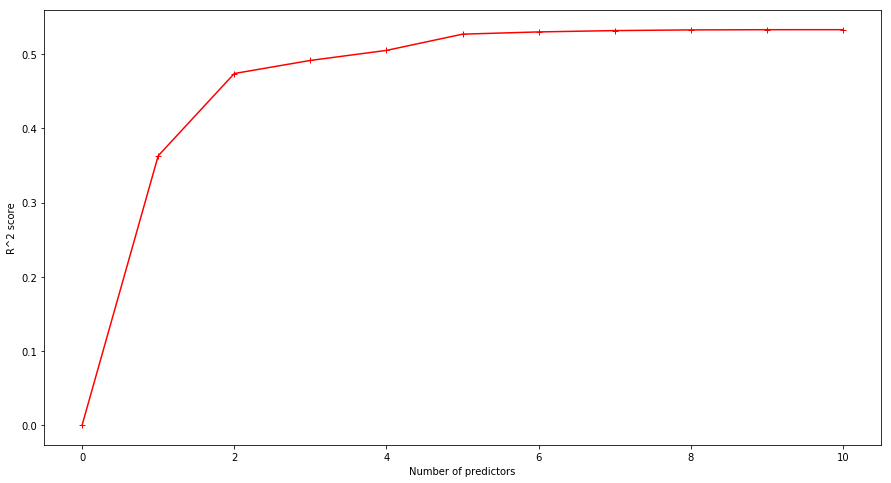

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(range(len(best_score)), best_score, 'r+-')
plt.xlabel('Number of predictors')
plt.ylabel('R^2 score')

for i,s in enumerate(best_score):
    print('\nScore of model with %i predictors has score %6.4f' % (i,s))
    print('\tSelected predictors', best_model[i])

**Observation**:

**Solution**:

**Observation**: We see that the $R^2$ score increases with the number of predictors.
The value improves only insignificantly for $p > 5$.

### Problem 1.2 - Implementing step 3 of the *best subset selection* algorithm
In the following tasks, you should implement step 3 of the *best subset selection* algorithm using the training data from the diabetes data set.

**Task**: Implement at least one of the performance criteria discussed in the lecture and above **as a function** that takes as arguments `y`, `yhat`, `d`, and `shat`, if necessary:
* AIC
    $$ AIC = \frac{1}{n \hat \sigma^2} (RSS + 2 d {\hat \sigma}^2)$$
* BIC
    $$ BIC = \frac{1}{n} (RSS + \log(n) d {\hat \sigma}^2)$$

* Adjusted R^2
    $$ R^2_{Adj} = 1 - \frac{RSS / (n - d - 1)}{TSS / (n - 1)} $$
  
with  $\hat{\sigma}^2$  referring to an estimate of the variance associated with each response in the linear model (estimated on a model containing all predictors):
    $$ {\hat \sigma}^2 = \frac{1}{n - p - 1} \sum_{i=1}^n (y_i - \hat y_i)^2.  $$
    
**Remember**: $TSS$ is the total sum of squares, which is defined by $\sum_{i=1}^n (y_i - \bar y)^2$.

In [ ]:
def RSS(y, yhat): return np.power(y-yhat,2).sum()
def TSS(y): return np.power(y-y.mean(),2).sum()

# Put your code here

**Solution**:

In [6]:
def RSS(y, yhat): return np.power(y-yhat,2).sum()
def TSS(y): return np.power(y-y.mean(),2).sum()

# Put your code here
def sigmaHat(X, y):
    n,p = X.shape
    lr = LinearRegression()
    lrfit = lr.fit(X, y)
    yhat = lrfit.predict(X)
    return np.sqrt(1./(n-p-1) * RSS(y, yhat))

def AIC(y, yhat, d, shat):
    n = len(y)
    return (RSS(y,yhat) + 2 * d * shat**2) / (n * shat**2)

def BIC(y, yhat, d, shat):
    n = len(y)
    return (RSS(y,yhat) + np.log(n) * d * shat**2) / (n)

def adjustedRSquare(y, yhat, d):
    n = len(y)
    return 1 - (RSS(y,yhat) / (n - d - 1)) / (TSS(y) / (n - 1))

**Task**:
1. Use the return values of the function `bestSubsetComputation` to perform step 3 of the *best subset selection* algorithm using the training data from the diabetes data set.
2. Plot your chosen score against the number of predictors.
3. Compute and mark the minimizer ($AIC$, $BIC$) or maximizer ($R^2$) in the plot.

**Solution**:

Text(0, 0.5, 'BIC')

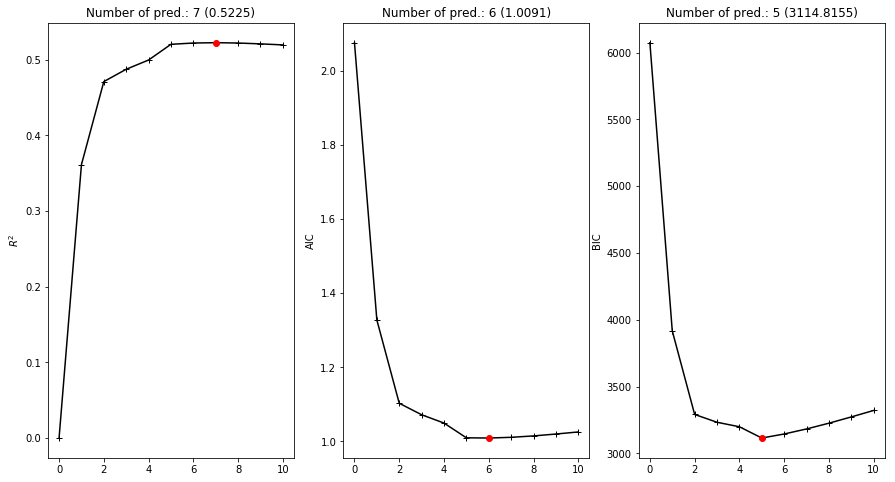

In [8]:
n,p = X_train.shape

R2score = []
AICscore = []
BICscore = []

lr = LinearRegression()
lrfit = lr.fit(X_train,y_train)
yhat = lrfit.predict(X_train)

shat = sigmaHat(X_train, y_train)

for d in range(p+1):
    if d == 0:
        yhat = y_train.mean() * np.ones_like(y_train)
    else:
        l = best_model[d]
        lr = LinearRegression()
        lrfit = lr.fit(X_train[:,l],y_train)
        yhat = lrfit.predict(X_train[:,l])
    R2score.append( adjustedRSquare(y_train, yhat, d) )
    AICscore.append( AIC(y_train, yhat, d, shat) )
    BICscore.append( BIC(y_train, yhat, d, shat) )

R2idx = np.argmax(R2score)
AICidx = np.argmin(AICscore)
BICidx = np.argmin(BICscore)

xr = range(p+1)

plt.rcParams['figure.figsize'] = (15,8)
fig, ax = plt.subplots(1,3)

ax[0].plot(xr,R2score,'k+-')
ax[0].plot(xr[R2idx], R2score[R2idx], 'ro')
ax[0].set_title('Number of pred.: %i (%6.4f)' % (R2idx, R2score[R2idx]))
ax[0].set_ylabel('$R^2$')

ax[1].plot(xr,AICscore,'k+-')
ax[1].plot(xr[AICidx], AICscore[AICidx], 'ro')
ax[1].set_title('Number of pred.: %i (%6.4f)' % (AICidx, AICscore[AICidx]))
ax[1].set_ylabel('AIC')

ax[2].plot(xr,BICscore,'k+-')
ax[2].plot(xr[BICidx], BICscore[BICidx], 'ro')
ax[2].set_title('Number of pred.: %i (%6.4f)' % (BICidx, BICscore[BICidx]))
ax[2].set_ylabel('BIC')

**Extra Task**: Implement the best subset selection algorithm as one function `bestSubsetSelection`.
You might use the function `bestSubsetComputation` as well as your scoring function(s).

**Solution**:

In [9]:
def bestSubsetSelection(X, y, scoring = 'aic'):
    """ Input: X - predictor array of size (n,p)
               y - array of size (n,)
               scoring - string variable, one of 'aic', 'bic', 'r2'
        Output: bps - best parameter selection
    """
    score = []
    def scoring_func(y, yhat, d):
        if scoring == 'r2':
            return adjustedRSquare(y, yhat, d)
        else:
            shat = sigmaHat(X,y)      
            if scoring == 'aic':
                return AIC(y, yhat, d, shat)
            elif scoring == 'bic':
                return BIC(y, yhat, d, shat)
            else:
                raise NameError('scoring not known')

    best_model, best_score = bestSubsetComputation(X, y)
    
    for d, l in enumerate(best_model):
        if d == 0:
            yhat = y.mean() * np.ones_like(y)
        else:
            lr = LinearRegression()
            lrfit = lr.fit(X[:,l],y)
            yhat = lrfit.predict(X[:,l])

        score.append( scoring_func(y, yhat, d) )
        
    if scoring == 'r2':
        best_idx = np.argmax(score)
    else:
        best_idx = np.argmin(score)
    
    return score[best_idx], best_model[best_idx]

# Test the implementation
optimal_score, optimal_model = bestSubsetSelection(X_train,y_train,'r2')
print(optimal_score)
print(optimal_model)

0.5225204821123409
(1, 2, 3, 4, 5, 7, 8)


# Homework 7

Implement either the **forward stepwise selection algorithm** or the **backward stepwise selection algorithm** as a function `forwardStepwiseSelection` or `backwardStepwiseSelection`, resp.

Use 10-fold cross-validation as a measure for model selection (step 3 of the algorithms).
 
Test your algorithm on the diabetes data set from above.